This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

data_path = Path('./data/data_000637.txt')

data_df = pd.read_csv(data_path)

print(f'the dataset contains {len(data_df)} records')

the dataset contains 1310720 records


In [3]:
N = int(5e4) # picked arbitrarily
data_df2 = pd.read_csv(data_path, nrows=N)
data_df2

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
49995,1,1,2,3869200664,1103,4
49996,1,1,4,3869200664,1105,14
49997,1,0,59,3869200664,1191,17
49998,1,0,32,3869200664,1191,1


2\. Estimate the number of BX in a ORBIT (the value 'x').

In [4]:
x = data_df['BX_COUNTER'].max()
print('x =', x)

x = 3563


3\. Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [5]:
def compute_run_time(df):
    abs_time = df['TDC_MEAS']*25/30 + df['BX_COUNTER']*25 + df['ORBIT_CNT']*x*25
    return (abs_time.max() - abs_time.min())*1e-9 # [s]
    
print(f'{N} measurements: {compute_run_time(data_df):.5f} s')
print(f'all measurements: {compute_run_time(data_df2):.5f} s')

50000 measurements: 0.98014 s
all measurements: 0.04424 s


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [6]:
data_df['TIME_NS'] = data_df['TDC_MEAS']*25/30 + data_df['BX_COUNTER']*25 + data_df['ORBIT_CNT']*x*25
data_df.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS
0,1,0,123,3869200167,2374,26,3.446490e+14
1,1,0,124,3869200167,2374,27,3.446490e+14
2,1,0,63,3869200167,2553,28,3.446490e+14
3,1,0,64,3869200167,2558,19,3.446490e+14
4,1,0,64,3869200167,2760,25,3.446490e+14


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [7]:
count_per_channel = data_df.groupby('TDC_CHANNEL').size().sort_values(ascending=False)
count_per_channel[:3]

TDC_CHANNEL
139    108059
64      66020
63      64642
dtype: int64

6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [8]:
non_empty_orbits = data_df['ORBIT_CNT'].unique() # Series.unique() returns a ndarray
print('non-empty orbits: ', non_empty_orbits.shape[0])

tdc139_df = data_df[data_df['TDC_CHANNEL'] == 139]
print('unique orbits from TDC_CHANNEL=139: ', tdc139_df['ORBIT_CNT'].unique().shape[0])

non-empty orbits:  11001
unique orbits from TDC_CHANNEL=139:  10976


7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

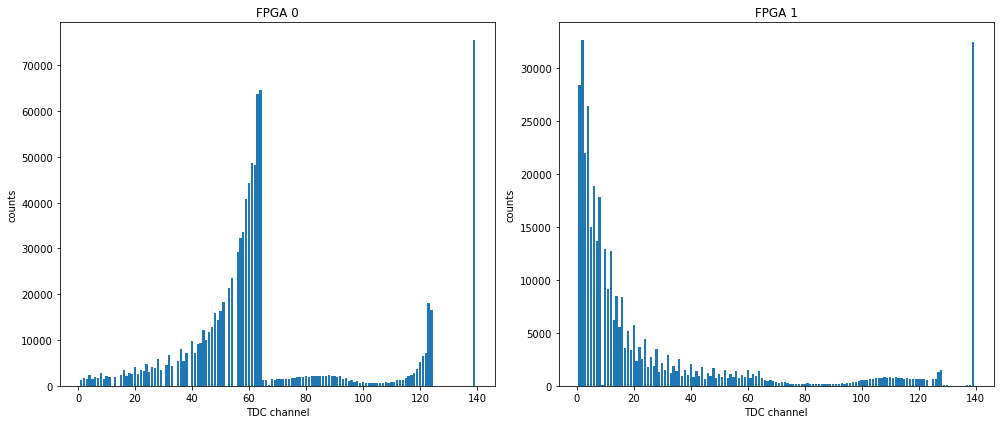

In [9]:
import matplotlib.pyplot as plt

fpga0 = data_df[data_df['FPGA'] == 0]
fpga1 = data_df[data_df['FPGA'] == 1]

counts0 = fpga0.groupby('TDC_CHANNEL').size()
counts1 = fpga1.groupby('TDC_CHANNEL').size()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax1.bar(counts0.index, counts0.values)
#ax1.hist(fpga0['TDC_CHANNEL'])
ax2.bar(counts1.index, counts1.values)

ax1.set_title('FPGA 0')
ax1.set_ylabel('counts')
ax1.set_xlabel('TDC channel')

ax2.set_title('FPGA 1')
ax2.set_ylabel('counts')
ax2.set_xlabel('TDC channel')

fig.tight_layout()